In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs
import random as rand

np.random.seed(3)

In [2]:
plot_size   = 20
plot_width  = 16
plot_height = 8

params = {'legend.fontsize': 'large',
          'figure.figsize': (plot_width,plot_height),
          'axes.labelsize': plot_size,
          'axes.titlesize': plot_size,
          'xtick.labelsize': plot_size*0.75,
          'ytick.labelsize': plot_size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)
plt.rcParams.update(params)

In [4]:
num_cities = 10
num_CS = 3
num_clients = num_cities - 1
num_vehicles = 2
vehicle_payload = 4

charging_time = 2
Capacity_CS = 2
Charging_duration = 3600 #second
soc_set = [0.98, 0.98, 0.98, 0.98]
V_max = [7, 7.5, 8, 8.5, 9, 9.5, 10]
a_max = [0.5, 1, 1.5, 2, 2.5]

C_batt = 10000
C_e =0 #0.18
C_t = 1

In [5]:
from scipy.spatial.distance import cdist
center_box = (1000, 1000)

cities_coord, _ = make_blobs(n_samples=num_cities,
                           centers=5,
                           cluster_std=150,
                           center_box=center_box,
                           random_state = 20)

all_names = [i for i in range(num_cities)]
client_names = [i for i in range(1, num_cities)]
all_coord_dict = {name: coord for name,coord in zip(all_names, cities_coord)}
client_coord_dict = {name: coord for name,coord in zip(client_names, cities_coord[1:])}

In [6]:
charging_coord, _ = make_blobs(n_samples=num_CS,
                           centers=5,
                           cluster_std=170,
                           center_box=center_box,
                           random_state = 5)

all_names_ = [i + num_cities for i in range(num_CS)]
charging_names = [i for i in range(num_cities, num_cities + num_CS)]
all_coord_dict_ = {name: coord for name,coord in zip(all_names_, charging_coord)}
charging_coord_dict = {name: coord for name, coord in zip(charging_names, charging_coord)}

<ipython-input-7-362cd2ad1884>:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cities_coord[1:, 0], cities_coord[1:, 1], s=plot_size*2, cmap='viridis');
<ipython-input-7-362cd2ad1884>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(charging_coord[:, 0], charging_coord[:, 1], s=plot_size*4, cmap='viridis', marker='s');
<ipython-input-7-362cd2ad1884>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cities_coord[0, 0], cities_coord[0, 1], s=plot_size*4, cmap='viridis');


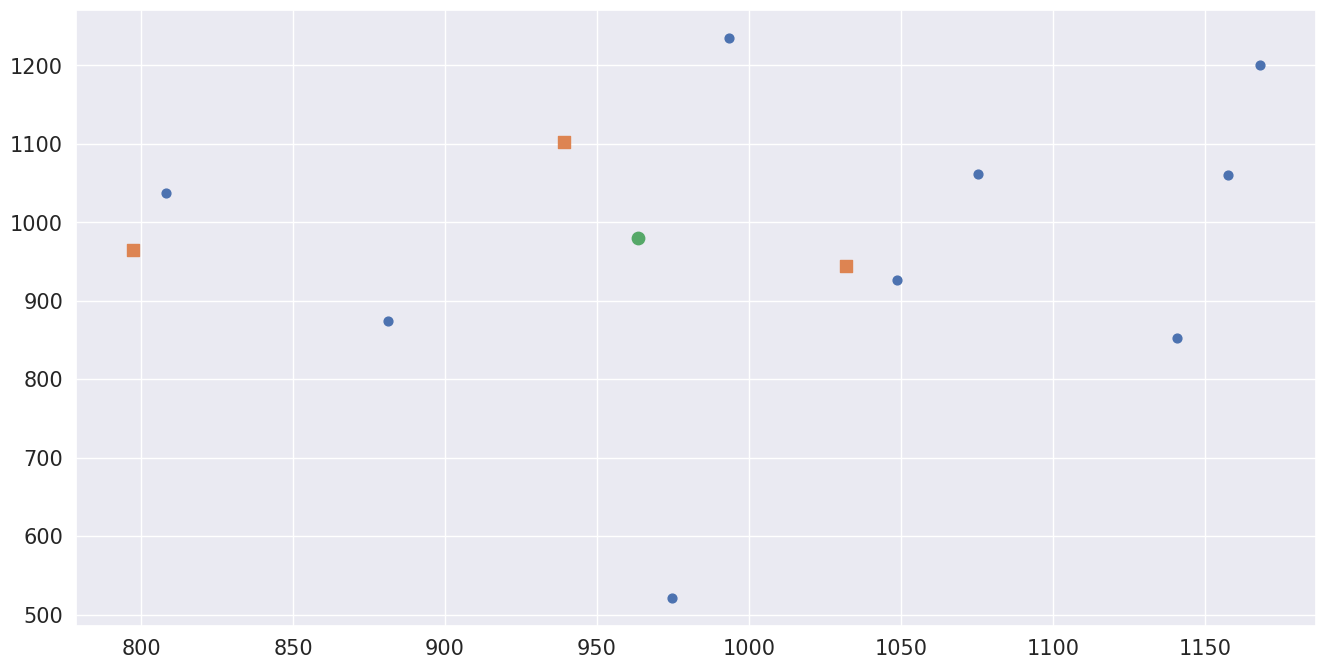

In [7]:
plt.scatter(cities_coord[1:, 0], cities_coord[1:, 1], s=plot_size*2, cmap='viridis');
plt.scatter(charging_coord[:, 0], charging_coord[:, 1], s=plot_size*4, cmap='viridis', marker='s');
plt.scatter(cities_coord[0, 0], cities_coord[0, 1], s=plot_size*4, cmap='viridis');

In [8]:
client_time_windows = [(0, 0)]
start_time = 9  # 9:00 hrs
end_time = 12  #  hrs

# Update client_coord_dict to include a deadline for each client
for client in client_coord_dict:
    window_width = rand.uniform(0.25, 0.5)
    start_time_window = rand.uniform(start_time, end_time - window_width)
    end_time_window = start_time_window + window_width

    client_time_windows.append((round(start_time_window, 2), min(round(end_time_window, 2), end_time)))

In [9]:
from scipy.spatial import distance

dist_matrix = distance.cdist(cities_coord, cities_coord, 'euclidean')
dist_chargestation = distance.cdist(cities_coord, charging_coord, 'euclidean')

In [10]:
import sys
!{sys.executable} -m pip install deap
import deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.0 MB/s eta 0:00:00


In [11]:
from deap import base, creator, tools

tb = base.Toolbox()

creator.create('Fitness_Func', base.Fitness, weights=(-1.0,-1))
creator.create('Individual', list, fitness=creator.Fitness_Func)

In [12]:
import copy

def chromo_create(_cities_names, _charging_names, V_max, a_max):
    schedule = copy.deepcopy(_cities_names)
    vehicle = list(np.random.randint(num_vehicles, size=len(schedule)))

    CS = []

    velocities = rand.sample(V_max, num_vehicles)
    acc = rand.sample(a_max, num_vehicles)

    mean_start_time = 10.5
    std_deviation = 5.0
    start_times = []
    for _ in range(num_vehicles):
        start_time = 0
        while start_time < 9 or start_time > 12 or start_time == 0:
            start_time = round(rand.normalvariate(mean_start_time, std_deviation))
        start_times.append(start_time)

    rand.shuffle(schedule)
    for i in range(len(schedule)):
        CS.append(rand.choice(_charging_names + [-1]))

    chromo = [schedule, vehicle, CS, start_times, velocities, acc]

    return chromo

In [13]:
def calculate_time(distance, acceleration, initial_velocity):
    #formula t = (-u + sqrt(u^2 + 2 * a * s)) / a
    time = (-initial_velocity + math.sqrt(initial_velocity**2 + 2 * acceleration * distance)) / acceleration
    return time

def calculate_velocity(initial_velocity, acceleration, distance):
    velocity =  math.sqrt(initial_velocity**2 + 2 * acceleration * distance)           #initial_velocity + acceleration * time
    return velocity

def calculate_acceleration(initial_velocity, time, distance):
    acceleration = ((2* distance)/ time **2) - ((2 * initial_velocity) / time)
    return acceleration

def calculate_displacement(time, initial_velocity, acceleration):
    displacement = initial_velocity * time + 0.5 * acceleration * time**2
    return displacement

In [14]:
def calculate_power_mechanical(velocity, acceleration):
    m_air = 1.32  # Air density in kg/m3
    C_w = 0.109  # Air drag coefficient
    mu_rr = 0.03 #rolling resistance coefficient
    A = 1.2  # Frontal area in square meters
    g = 9.8  # Acceleration due to gravity
    mass = 20 #kg
    alpha = 0

    # Calculate the mechanical power
    power_mech = (0.5 * m_air * C_w * A * velocity**3) + (mass * g * velocity * math.sin(alpha)) + (mass * g * mu_rr * velocity * math.cos(alpha)) + (mass * acceleration * velocity)

    return power_mech

In [15]:
# Function to update SoC based on current and return corresponding voltage
def update_soc(soc_old, power):
    # Constant battery parameters
    capacity = 4 * 3600  # Battery capacity in Ampere-second
    current = calculate_current(soc_old, power)
    # Calculate SoC change
    t_sample = 0.01
    soc_change = (current * t_sample) / capacity
    return soc_change

In [16]:
# Function to calculate current
def calculate_current(soc, power_mechanical):
    voltage = soc_to_voltage(soc)
    current = power_mechanical / voltage
    return current

In [17]:
# Function to convert soc to voltage
def soc_to_voltage(soc):
    voltage = (3.32 * math.exp(0.217 * soc)) - (0.784 * math.exp(-16.74 * soc))
    return voltage

In [18]:
def calculate_angle(p1, p2):
    delta_x = p2[0] - p1[0]
    delta_y = p2[1] - p1[1]
    return np.arctan2(delta_y, delta_x)

In [19]:
def chromo_eval(_dist_matrix, dist_chargestation, _chromo):
    soc_cost = 0
    energy_cost = 0
    Time_cost = 0
    changesoc = 0

    soc_values = []
    power_values = []
    velocity_values = []
    accelaration_value = []
    time_values = []
    displacement_values = []
    energy_values = []
    charging_station_usage = {}
    soc_change = []

    trace_cs = {}

    #finding route coresponding to each vehicle
    route_set = [[] for _ in range(num_vehicles)]
    for s, v, c in zip(_chromo[0], _chromo[1], _chromo[2]):
        route_set[v].append((s, c))

    #finding the number of charging for each vehicle ---> penalize if more than charging_time variable
    charging_count_per_vehicle = [sum(1 for _, c in vehicle_route if c != -1) for vehicle_route in route_set]
    soc_cost += sum([count - charging_time for count in charging_count_per_vehicle if count > charging_time]) * 0.2

    for i, route in enumerate(route_set):
        arrival_time =  _chromo[3][i]
        v_max = _chromo[4][i]
        acceleration = _chromo[5][i]
        counter_undervalue = 0
        previous_velocity = 0

        energy_total = 0
        arrived_time = 0
        soc = 0.98

        vehicle_soc_values = [soc]
        vehicle_power_values = [0]
        vehicle_velocity_values = [0]
        vehicle_accelaration_values = []
        vehicle_displacement = []
        next_itr_charging =  False
        vehicle_travel_time = 0

        flat_route = [item for city in route for item in city]
        flat_route.append(0)
        Current_Window = 0
        for p in range(0, len(flat_route)):
            if p == 0:
                _i = 0  # Depot
                _j = flat_route[0]
                distance = _dist_matrix[_i][_j]
                Current_Window = client_time_windows[_j]
                #angel = calculate_angle(all_coord_dict[_i], all_coord_dict[_j])

            elif p == len(flat_route) -1 and flat_route[p - 1] == -1:
                break

            elif p == len(flat_route) -1:
                _j = flat_route[p -1]
                if _j != -1:
                  _i = 0  # Depot
                  distance = dist_chargestation[_i][_j - num_cities]
                  #angel = calculate_angle(all_coord_dict_[_j], all_coord_dict[_i])

            elif p == len(flat_route) - 2 and flat_route[p] == -1:
                _j = 0
                _i = flat_route[p - 1]
                distance = _dist_matrix[_i][_j]
                #angel = calculate_angle(all_coord_dict[_j], all_coord_dict[_i])

            elif flat_route[p] == -1:
                    _i = flat_route[p - 1]
                    _j = flat_route[p + 1]
                    distance = _dist_matrix[_i][_j]
                    Current_Window = client_time_windows[_j]
                    #angel = calculate_angle(all_coord_dict[_i], all_coord_dict[_j])
            else:
                if p % 2 == 0:
                    if flat_route[p - 1] == -1:
                        continue
                    else:
                        _i = flat_route[p]
                        _j = flat_route[p - 1]
                        #angel = calculate_angle(all_coord_dict_[_j], all_coord_dict[_i])
                        _j = _j - num_cities
                        Current_Window = client_time_windows[_i]
                        distance = dist_chargestation[_i][_j]

                else:
                    _i = flat_route[p - 1]
                    _j = flat_route[p]
                    CS = _j
                    #angel = calculate_angle(all_coord_dict[_i], all_coord_dict_[_j])
                    _j = _j - num_cities
                    distance = dist_chargestation[_i][_j]
                    next_itr_charging = True

            acceleration = _chromo[5][i]
            vehicle_accelaration_values.append(acceleration)

            total_dis = 0
            traverse_distance = 0

            while traverse_distance < distance:
                  time_seconds  = 0.01
                  vehicle_travel_time += time_seconds

                  displacement = calculate_displacement(time_seconds, previous_velocity, acceleration)
                  traverse_distance += displacement
                  total_dis += displacement

                  # if vehicle reach the customer
                  if traverse_distance >= distance and next_itr_charging == False:
                      arrival_time +=  round(vehicle_travel_time / 3600, 2)

                      if arrival_time > Current_Window[1]:
                            Time_cost +=  1.5 *(arrival_time - Current_Window[1])
                      if arrival_time < Current_Window[0]:
                            Time_cost +=  1.5 *(Current_Window[0] - arrival_time)

                      previous_velocity = 0
                      acceleration = 0
                      power_mech = calculate_power_mechanical(previous_velocity, acceleration)

                      vehicle_accelaration_values.append(acceleration)
                      vehicle_velocity_values.append(previous_velocity)
                      vehicle_power_values.append(power_mech)
                      vehicle_soc_values.append(soc)


                  #if the stop point is CS
                  elif traverse_distance >= distance and next_itr_charging == True:
                      time = 0
                      start_t = _chromo[3][i] + round(vehicle_travel_time / 3600, 2)
                      end_t = _chromo[3][i] + round(vehicle_travel_time+ Charging_duration / 3600, 2)
                      # Update trace_cs tracking for the specific CS
                      if CS not in trace_cs:
                          trace_cs[CS] = {}
                          trace_cs[CS][i] = [(start_t, end_t)]
                      else:
                          if i not in trace_cs[CS]:
                              for v_id, visit_times in trace_cs[CS].items():
                                    for visit in visit_times:
                                        if  visit[0] < end_t and start_t < visit[1]:
                                            time += 1
                              if time > Capacity_CS:
                                    soc_cost += 1.5 * (time - Capacity_CS)

                              trace_cs[CS][i] = [(start_t, end_t)]
                          else:
                              for v_id, visit_times in trace_cs[CS].items():
                                    for visit in visit_times:
                                        if  visit[0] < end_t and start_t < visit[1]:
                                            time += 1
                              if time > Capacity_CS:
                                    soc_cost += 1.5 * (time - Capacity_CS)
                              trace_cs[CS][i].append((start_t, end_t))

                      vehicle_travel_time += Charging_duration
                      soc_cost += 0.7 * (0.98 - soc)
                      soc = 0.98
                      vehicle_soc_values.append(soc)
                      next_itr_charging =  False

                  else:
                      #calculate velocity at the end of the displacement
                      previous_velocity = calculate_velocity(previous_velocity, acceleration, displacement)
                      #if the calculated velocity is more than max speed of vehicle
                      if previous_velocity >= v_max:
                          previous_velocity = v_max
                          acceleration = 0

                      vehicle_displacement.append(total_dis)
                      vehicle_accelaration_values.append(acceleration)
                      vehicle_velocity_values.append(previous_velocity)

                      #calculate power
                      power_mech = calculate_power_mechanical(previous_velocity, acceleration)
                      vehicle_power_values.append(power_mech)

                      #calculate energy
                      energy_total += power_mech * time_seconds

                      soc_new = update_soc(soc, power_mech)
                      soc = soc - soc_new
                      vehicle_soc_values.append(soc)

                      if soc <= 0:
                          soc_cost +=  np.Inf
                          break

                      if soc <= 0.25:
                          counter_undervalue +=1
                          soc_cost += 5.5 * counter_undervalue

        time_values.append(round(vehicle_travel_time / 3600, 2))
        soc_values.append(vehicle_soc_values)
        energy_values.append(energy_total)

    for v_soc in soc_values:
        if len(v_soc)== 1:
            soc_cost += 5* sum([v_soc[-1] - v_soc_other[-1]  for v_soc_other in soc_values])
        difference = v_soc[0] - v_soc[-1]
        soc_change.append(difference)

    soc_cost += sum(soc_change)
    energy_cost = sum(energy_values)
    Time_cost += sum(time_values)

    soc = C_batt * soc_cost
    energy = C_e * energy_cost
    time = C_t * Time_cost

    return soc,time


def get_route(_chromo):
    route_set = [([],_chromo[3][i],_chromo[4][i],_chromo[5][i]) for i in range(num_vehicles)]
    for s, v, c in zip(_chromo[0], _chromo[1], _chromo[2]):
        route_set[v][0].append((s, c))
    return route_set


def calc_route_cost(_dist_matrix, _route):
    if not _route:
        return 0
    dist = dist_matrix[_route[-1], 0] + dist_matrix[0, _route[0]]

    for p in range(len(_route) - 1):
        _i = _route[p]
        _j = _route[p + 1]
        dist += _dist_matrix[_i][_j]
    return dist

In [20]:
def crossover(_chromo1, _chromo2):

    cuts = get_chromo_cut()
    partial_crossover(_chromo1[0], _chromo2[0], cuts)
    partial_crossover_CS(_chromo1[2], _chromo2[2], cuts)


    cuts1 = get_chromo_cut()
    cuts2 = get_chromo_cut(cuts1[2])

    cutst = get_chromo_cut_()
    cutstt = get_chromo_cut_()


    cutsv = get_chromo_cut_()
    cutsvv = get_chromo_cut_()

    cutsa = get_chromo_cut_()
    cutsaa = get_chromo_cut_()

    swap_genes(_chromo1[1], _chromo2[1], cuts1, cuts2)
    swap_genes(_chromo1[3], _chromo2[3], cutst, cutst)
    swap_genes(_chromo1[4], _chromo2[4], cutsv, cutsv)
    swap_genes(_chromo1[5], _chromo2[5], cutsa, cutsa)

def partial_crossover(_chromo1, _chromo2, cuts):
    size = len(_chromo1)
    p1, p2 = [0] * size, [0] * size

    for i in range(size):
        p1[_chromo1[i] - 1] = i
        p2[_chromo2[i] - 1] = i

    for i in range(cuts[0], cuts[1]):

        temp1 = _chromo1[i] - 1
        temp2 = _chromo2[i] - 1

        _chromo1[i], _chromo1[p1[temp2]] = temp2 + 1, temp1 + 1
        _chromo2[i], _chromo2[p2[temp1]] = temp1 + 1, temp2 + 1

        p1[temp1], p1[temp2] = p1[temp2], p1[temp1]
        p2[temp1], p2[temp2] = p2[temp2], p2[temp1]

def partial_crossover_CS(_chromo1, _chromo2, cuts):
    size = len(_chromo1)
    p1, p2 = [0] *2* size, [0] * 2* size

    for i in range(size):
        p1[_chromo1[i] - 1] = i
        p2[_chromo2[i] - 1] = i

    for i in range(cuts[0], cuts[1]):

        temp1 = _chromo1[i] - 1
        temp2 = _chromo2[i] - 1

        _chromo1[i], _chromo1[p1[temp2]] = temp2 + 1, temp1 + 1
        _chromo2[i], _chromo2[p2[temp1]] = temp1 + 1, temp2 + 1

        p1[temp1], p1[temp2] = p1[temp2], p1[temp1]
        p2[temp1], p2[temp2] = p2[temp2], p2[temp1]


def get_chromo_cut(cut_range=None, mutation=False):
    if mutation:
        randrange = num_clients
    else:
        randrange = num_clients + 1

    if cut_range is None:
        cut1 = rand.randrange(randrange)
        cut2 = rand.randrange(randrange)
        if cut1 > cut2:
            tmp = cut2
            cut2 = cut1
            cut1 = tmp
        cut_range = cut2 - cut1
    else:

        cut1 = rand.randrange(num_clients + 1 - cut_range)
        cut2 = cut1 + cut_range
    return cut1, cut2, cut_range

def get_chromo_cut_():

    if num_vehicles == 2:
        cut1, cut2 = 0, 1
        return cut1, cut2

    randrange = num_vehicles - 1
    cut1 = rand.randrange(randrange)
    cut2 = rand.randrange(randrange)

    while cut1 == cut2:
        cut2 = rand.randrange(randrange)

    if cut1 > cut2:
        cut1, cut2 = cut2, cut1

    return cut1, cut2


def swap_genes(chrom1, chrom2, cuts1, cuts2):
    tmp = chrom1[cuts1[0]:cuts1[1]]
    chrom1[cuts1[0]:cuts1[1]] = chrom2[cuts2[0]:cuts2[1]]
    chrom2[cuts2[0]:cuts2[1]] = tmp

In [21]:
def mutation(_chromo):
    if np.random.rand() < 0.5:
        swap_gene(_chromo)
        change_gene_CS(_chromo)
    else:
        shuffle_gene(_chromo)
        change_gene_CS(_chromo)


def swap_gene(_chromo):
    cuts = get_chromo_cut(mutation=True)
    cuts_ = get_chromo_cut_()
    cuts_1 = get_chromo_cut_()

    if np.random.rand() < 0.5:
        tmp = _chromo[0][cuts[0]]
        _chromo[0][cuts[0]] = _chromo[0][cuts[1]]
        _chromo[0][cuts[1]] = tmp

        tmp_cs = _chromo[2][cuts[0]]
        _chromo[2][cuts[0]] = _chromo[2][cuts[1]]
        _chromo[2][cuts[1]] = tmp_cs


        tmp_t = _chromo[3][cuts_[0]]
        _chromo[3][cuts_[0]] = _chromo[3][cuts_[1]]
        _chromo[3][cuts_[1]] = tmp_t

        tmp_a = _chromo[5][cuts_1[0]]
        _chromo[5][cuts_1[0]] = _chromo[5][cuts_1[1]]
        _chromo[5][cuts_1[1]] = tmp_a

    else:
        tmp = _chromo[1][cuts[0]]
        _chromo[1][cuts[0]] = _chromo[1][cuts[1]]
        _chromo[1][cuts[1]] = tmp

        tmp_cs = _chromo[2][cuts[0]]
        _chromo[2][cuts[0]] = _chromo[2][cuts[1]]
        _chromo[2][cuts[1]] = tmp_cs

        tmp_v = _chromo[4][cuts_[0]]
        _chromo[4][cuts_[0]] = _chromo[4][cuts_[1]]
        _chromo[4][cuts_[1]] = tmp_v


def shuffle_gene(_chromo):
    cuts = get_chromo_cut(mutation=True)
    cuts_ = get_chromo_cut_()
    cuts_1 = get_chromo_cut_()

    if np.random.rand() < 0.5:
        tmp = _chromo[0][cuts[0]:cuts[1]]
        np.random.shuffle(tmp)
        _chromo[0][cuts[0]:cuts[1]] = tmp

        tmp_cs = _chromo[2][cuts[0]:cuts[1]]
        np.random.shuffle(tmp_cs)
        _chromo[2][cuts[0]:cuts[1]] = tmp_cs

        tmp_v = _chromo[4][cuts_[0]:cuts_[1]]
        np.random.shuffle(tmp_v)
        _chromo[4][cuts_[0]:cuts_[1]] = tmp_v

    else:
        tmp = _chromo[1][cuts[0]:cuts[1]]
        np.random.shuffle(tmp)
        _chromo[1][cuts[0]:cuts[1]] = tmp

        tmp_cs = _chromo[2][cuts[0]:cuts[1]]
        np.random.shuffle(tmp_cs)
        _chromo[2][cuts[0]:cuts[1]] = tmp_cs

        tmp_t = _chromo[3][cuts_[0]:cuts_[1]]
        np.random.shuffle(tmp_t)
        _chromo[3][cuts_[0]:cuts_[1]] = tmp_t

        tmp_a = _chromo[5][cuts_1[0]:cuts_1[1]]
        np.random.shuffle(tmp_a)
        _chromo[5][cuts_1[0]:cuts_1[1]] = tmp_a


def change_gene_CS(_chromo):
    index = rand.randint(0, len(_chromo[2])-1)
    _chromo[2][index] = rand.choice(charging_names + [-1])

    index_t = rand.randint(0, len(_chromo[3])-1)
    num = rand.randint(-12, 12)
    if 7 <= _chromo[3][index_t] + num <= 13 and _chromo[3][index_t] + num != 0:
        _chromo[3][index_t] = _chromo[3][index_t] + num
    else:
        _chromo[3][index_t] = rand.randint(7, 12)

    index_v = rand.randint(0, len(_chromo[4])-1)
    _chromo[4][index_v] = rand.choice(V_max)

    index_a= rand.randint(0, len(_chromo[5])-1)
    _chromo[5][index_a] = rand.choice(a_max)


In [23]:
def feasibility(_chromo):
    excess_payload = [vehicle_payload - _chromo[1].count(i) for i in range(num_vehicles)]
    _vehicle_id = [i for i in range(num_vehicles)]

    while any(_p < 0 for _p in excess_payload):
        v_id = next(i for i,_p in enumerate(excess_payload) if _p < 0)
        available_vehicles = [i for i,e in enumerate(excess_payload) if e > 0]

        if len(available_vehicles) == 0:
            raise('INFEASIBLE SOLUTION: No available vehicle to accept excess cargo. Increase the number of vehicles or the vehcile payload')

        idx = [i for i, x in enumerate(_chromo[1]) if x == v_id]
        to_vehicle = rand.choice(available_vehicles)
        idx_to_move = rand.choice(idx)
        _chromo[1][idx_to_move] = to_vehicle
        excess_payload[v_id] += 1
        excess_payload[to_vehicle] -= 1

In [24]:
tb.register('indexes', chromo_create, client_names, charging_names, V_max, a_max)
tb.register('individual', tools.initIterate, creator.Individual, tb.indexes)
tb.register('population', tools.initRepeat, list, tb.individual)
tb.register('evaluate', chromo_eval, dist_matrix, dist_chargestation)
tb.register('select', tools.selTournament)
tb.register('mate', crossover)
tb.register('mutate', mutation)
tb.register('feasibility', feasibility)

In [26]:
num_population = 200
num_generations = 300
prob_crossover = .4
prob_mutation = .6

In [27]:
population = tb.population(n=num_population)

In [28]:
fitness_set = list(tb.map(tb.evaluate, population))
for ind, fit in zip(population, fitness_set):
    ind.fitness.values = fit

In [29]:
best_fit_list = []
best_sol_list = []

best_fit = np.Inf

for gen in range(0, num_generations):

    if (gen % 10 == 0):
        print(f'Generation: {gen:4} | Fitness: {best_fit:.2f}' )

    offspring = tb.select(population, len(population), tournsize=3)
    offspring = list(map(tb.clone, offspring))

    for child1, child2 in zip(offspring[0::2], offspring[1::2]):
        if np.random.random() < prob_crossover:
            tb.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for chromo in offspring:
        if np.random.random() < prob_mutation:
            tb.mutate(chromo)
            del chromo.fitness.values

    #for chromo in offspring:
        #tb.feasibility(chromo)
        #tb.feasibilitySOC(chromo)

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitness_set = map(tb.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitness_set):
        ind.fitness.values = fit

    population[:] = offspring

    curr_best_sol = tools.selBest(population, 1)[0]
    curr_best_fit = curr_best_sol.fitness.values[0]

    if curr_best_fit < best_fit:
        best_sol = curr_best_sol
        best_fit = curr_best_fit

    best_fit_list.append(best_fit)
    best_sol_list.append(best_sol)

Generation:    0 | Fitness: inf
Generation:   10 | Fitness: 4091.81
Generation:   20 | Fitness: 3886.34
Generation:   30 | Fitness: 3873.90
Generation:   40 | Fitness: 3873.90
Generation:   50 | Fitness: 3873.90
Generation:   60 | Fitness: 3873.90
Generation:   70 | Fitness: 3873.90
Generation:   80 | Fitness: 3873.90
Generation:   90 | Fitness: 3873.90
Generation:  100 | Fitness: 3873.90
Generation:  110 | Fitness: 3873.90
Generation:  120 | Fitness: 3873.90
Generation:  130 | Fitness: 3763.43
Generation:  140 | Fitness: 3590.77
Generation:  150 | Fitness: 3590.77
Generation:  160 | Fitness: 3590.77
Generation:  170 | Fitness: 3590.77
Generation:  180 | Fitness: 3590.77
Generation:  190 | Fitness: 3590.77
Generation:  200 | Fitness: 3590.77
Generation:  210 | Fitness: 3590.77
Generation:  220 | Fitness: 3590.77
Generation:  230 | Fitness: 3590.77
Generation:  240 | Fitness: 3590.77
Generation:  250 | Fitness: 3590.77
Generation:  260 | Fitness: 3590.77
Generation:  270 | Fitness: 3590

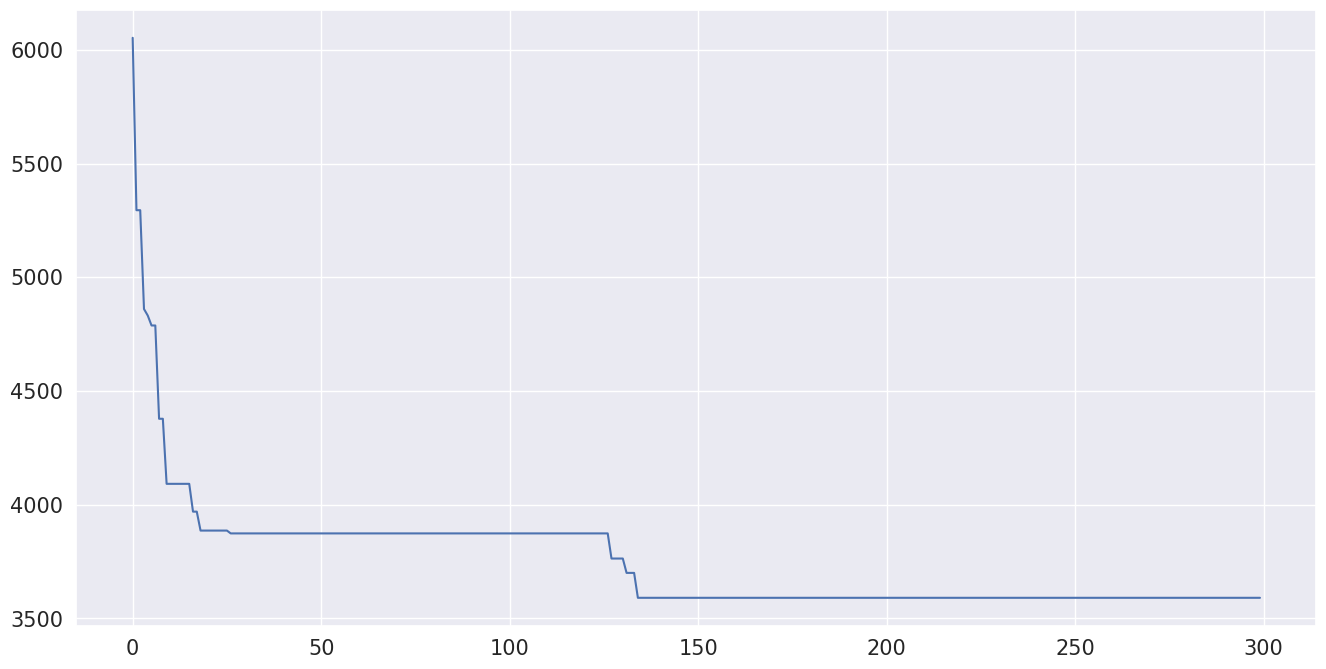

In [30]:
plt.plot(best_fit_list)
plt.show()

In [31]:
best_routes = get_route(best_sol)
print(best_routes)

[([(5, -1), (6, -1), (8, -1), (9, -1), (7, -1), (1, -1), (4, 11)], 9, 7, 0.5), ([(2, -1), (3, 12)], 13, 7, 1.5)]


<ipython-input-32-163f8eddf283>:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cities_coord[1:, 0], cities_coord[1:, 1], s=plot_size*2, cmap='viridis')
<ipython-input-32-163f8eddf283>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(charging_coord[:, 0], charging_coord[:, 1], s=plot_size*4, cmap='viridis', marker='s')
<ipython-input-32-163f8eddf283>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cities_coord[0, 0], cities_coord[0, 1], s=plot_size*4, cmap='viridis')


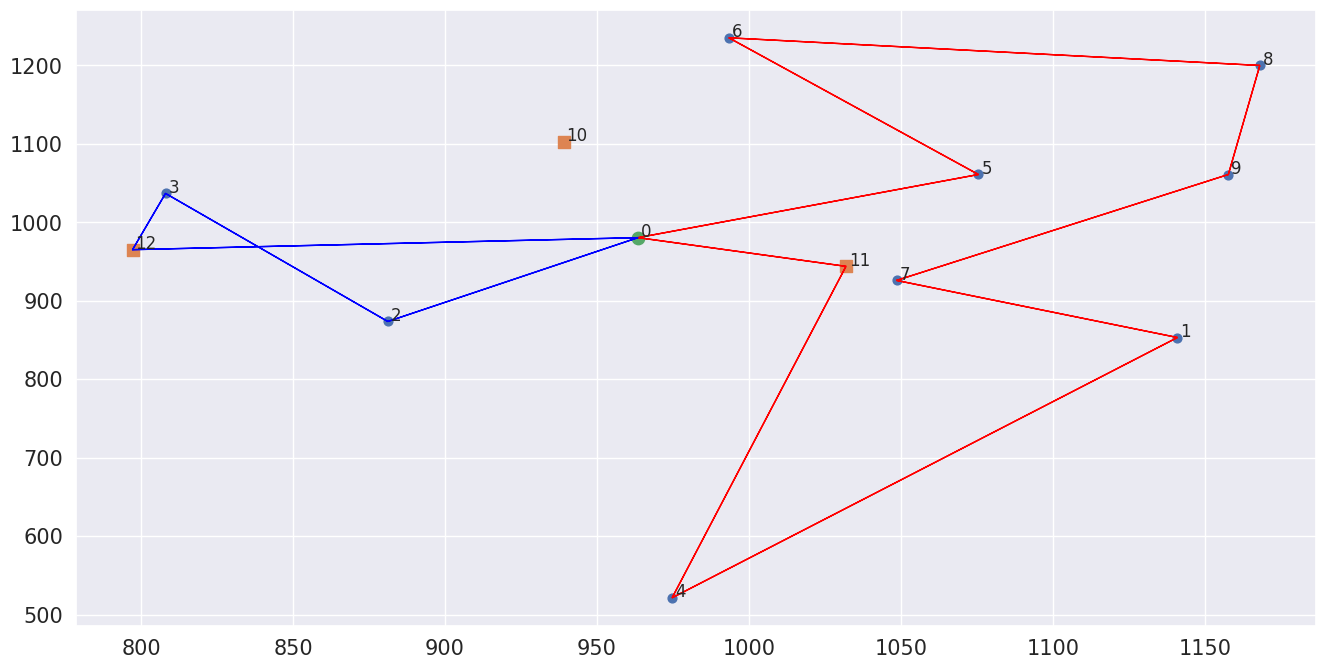

In [32]:
plt.scatter(cities_coord[1:, 0], cities_coord[1:, 1], s=plot_size*2, cmap='viridis')
plt.scatter(charging_coord[:, 0], charging_coord[:, 1], s=plot_size*4, cmap='viridis', marker='s')
plt.scatter(cities_coord[0, 0], cities_coord[0, 1], s=plot_size*4, cmap='viridis')

colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, txt in enumerate(all_names):
    plt.annotate(txt, (cities_coord[i, 0]+1, cities_coord[i, 1]+1))

for i, txt in enumerate(all_names_):
    plt.annotate(txt, (charging_coord[i, 0]+1, charging_coord[i, 1]+1))

for i, r in enumerate(best_routes):
    route = [0]
    r = [item for city in r[0] for item in city]
    for step in r:
        if step != -1:
            route.append(step)
    route.append(0)
    colour = colors[i]
    for p in range(len(route) - 1):
        i = route[p]
        j = route[p + 1]
        if j < num_cities and i < num_cities:
            plt.arrow(cities_coord[i, 0], cities_coord[i, 1],
                      cities_coord[j, 0] - cities_coord[i, 0],
                      cities_coord[j, 1] - cities_coord[i, 1], color=colour)
        if j >= num_cities and i < num_cities:
            j = j - num_cities
            plt.arrow(cities_coord[i, 0], cities_coord[i, 1],
                      charging_coord[j, 0] - cities_coord[i, 0],
                      charging_coord[j, 1] - cities_coord[i, 1], color=colour)

        if i >= num_cities and j < num_cities:
            i = i - num_cities
            plt.arrow(charging_coord[i, 0], charging_coord[i, 1],
                      cities_coord[j, 0] - charging_coord[i, 0],
                      cities_coord[j, 1] - charging_coord[i, 1], color=colour)
plt.show()

In [33]:
def soc_power_velocity(route_set, dist_matrix ,dist_chargestation):
    soc_init = 1
    soc_threshold = 0.2
    soc_cost = 0
    energy_cost = 0
    changesoc = 0

    soc_values = []
    power_values = []
    velocity_values = []
    accelaration_value = []
    time_values = []
    displacement_values = []
    energy_values = []
    time_traveling = []
    records = []

    for i, route in enumerate(route_set):
        arrival_times = {}
        destination_data = []

        travel_time = 0
        counter_undervalue = 0
        previous_velocity = 0
        v_max = route[2]
        acceleration = route[3]
        arrival_time = route[1]

        energy_total = 0
        arrived_time = 0
        soc = soc_set[i]

        vehicle_soc_values = [soc]
        vehicle_power_values = [0]
        vehicle_velocity_values = [0]
        vehicle_accelaration_values = []
        vehicle_displacement = [0]
        vehicle_time = []
        vehicle_time_travel = [0]
        next_itr_charging =  False

        flat_route = [item for city in route[0] for item in city]
        flat_route.append(0)
        for p in range(0, len(flat_route)):
            if p == 0:
                _i = 0  # Depot (city 0)
                _j = flat_route[0]
                des = _j
                distance = dist_matrix[_i][_j]  # Distance from depot to first city

            elif p == len(flat_route) -1 and flat_route[p - 1] == -1:
                break

            elif p == len(flat_route) -1:
                _j = flat_route[p -1]
                if _j != -1:
                  _i = 0  # Depot (city 0)
                  distance = dist_chargestation[_i][_j - num_cities]
            elif p == len(flat_route) - 2 and flat_route[p] == -1:
                _i = 0
                _j = flat_route[p - 1]
                des = _i
                distance = dist_matrix[_i][_j]

            elif flat_route[p] == -1:
                    _i = flat_route[p - 1]
                    _j = flat_route[p + 1]
                    des = _j
                    distance = dist_matrix[_i][_j]
            else:
                if p % 2 == 0:
                    if flat_route[p - 1] == -1:
                        continue
                    else:
                        _i = flat_route[p]
                        _j = flat_route[p - 1]
                        des = _i
                        _j = _j - num_cities
                        distance = dist_chargestation[_i][_j]
                else:
                    _i = flat_route[p - 1]
                    _j = flat_route[p]
                    des = _j
                    _j = _j - num_cities
                    distance = dist_chargestation[_i][_j]
                    next_itr_charging = True


            total_dis = 0
            #travel_time = 0
            traverse_distance = 0

            acceleration = route[3]
            vehicle_accelaration_values.append(acceleration)

            while traverse_distance < distance:
                  time_seconds  = 0.01
                  travel_time += time_seconds

                  displacement = calculate_displacement(time_seconds, previous_velocity, acceleration)
                  traverse_distance += displacement
                  total_dis += displacement

                  vehicle_displacement.append(total_dis)


                  # if vehicle reach the customer or CS, it should stop
                  if traverse_distance >= distance and next_itr_charging == False:
                      arrival_time +=  round(travel_time/3600,2)
                      arrival_times[des] = arrival_time

                      vehicle_time_travel.append(travel_time)

                      previous_velocity = 0
                      acceleration = 0
                      vehicle_accelaration_values.append(acceleration)
                      vehicle_velocity_values.append(previous_velocity)

                      power_mech = calculate_power_mechanical(previous_velocity, acceleration)
                      vehicle_power_values.append(power_mech)

                      vehicle_soc_values.append(soc)
                      data = {'soc': soc, 'acceleration': acceleration, 'velocity': previous_velocity , 'Time': travel_time, 'power': power_mech}
                      destination_data.append(data)

                  elif next_itr_charging == True and traverse_distance >= distance:
                      arrival_time +=  round(travel_time/3600,2)
                      arrival_times[des] = arrival_time

                      previous_velocity = 0
                      acceleration = 0
                      vehicle_accelaration_values.append(acceleration)
                      vehicle_velocity_values.append(previous_velocity)

                      power_mech = calculate_power_mechanical(previous_velocity, acceleration)
                      vehicle_power_values.append(power_mech)

                      travel_time += charging_time
                      vehicle_time_travel.append(travel_time)

                      soc = 0.98
                      vehicle_soc_values.append(soc)


                      data = {'soc': soc, 'acceleration': acceleration, 'velocity': previous_velocity , 'Time': travel_time, 'power': power_mech}
                      destination_data.append(data)
                      next_itr_charging =  False

                  else:

                      vehicle_time_travel.append(travel_time)

                      #calculate velocity at the end of the displacement
                      previous_velocity = calculate_velocity(previous_velocity, acceleration, displacement) #calculate velocity

                      #if the calculated velocity is more than max speed of vehicle
                      if previous_velocity >= v_max:
                          previous_velocity = v_max
                          acceleration = 0

                      vehicle_accelaration_values.append(acceleration)
                      vehicle_velocity_values.append(previous_velocity)

                      #calculate power
                      power_mech = calculate_power_mechanical(previous_velocity, acceleration)
                      vehicle_power_values.append(power_mech)

                      #calculate energy
                      energy_total += power_mech * time_seconds

                      #calculate new soc basd new power
                      soc_new = update_soc(soc, power_mech)
                      soc = soc - soc_new
                      vehicle_soc_values.append(soc)
                      data = {'soc': soc, 'acceleration': acceleration, 'velocity': previous_velocity , 'Time': travel_time, 'power': power_mech}
                      destination_data.append(data)


        #aqcuire time, soc, power, energy, velocity, acc for each vehicle
        time_values.append(arrival_times)
        soc_values.append(vehicle_soc_values)
        power_values.append(vehicle_power_values)
        energy_values.append(energy_total)
        velocity_values.append(vehicle_velocity_values)
        accelaration_value.append(vehicle_accelaration_values)
        displacement_values.append(vehicle_displacement)
        time_traveling.append(vehicle_time_travel)
        records.append(destination_data)

    return soc_values, power_values, velocity_values, accelaration_value, displacement_values, time_values, time_traveling, records


In [34]:
def plot_power_velocity_soc(soc_values, power_values, velocity_values, accelaration_value, displacement_values):
    num_vehicles = len(power_values)
    fig, axs = plt.subplots(num_vehicles, 5, figsize=(16, 10))

    fig.subplots_adjust(hspace=1)  # Increase vertical spacing between subplots

    for i in range(num_vehicles):
        axs[i, 0].plot(power_values[i])
        axs[i, 0].set_xlabel('Time', fontsize=10)
        axs[i, 0].set_ylabel('Power mechanical', fontsize=10)
        axs[i, 0].set_title('Power for Vehicle {}'.format(i+1),fontsize=10)

        axs[i, 1].plot(velocity_values[i])
        axs[i, 1].set_xlabel('Time', fontsize=10)
        axs[i, 1].set_ylabel('Velocity', fontsize=10)
        axs[i, 1].set_title('Velocity for Vehicle {}'.format(i+1), fontsize=10)

        axs[i, 2].plot(soc_values[i])
        axs[i, 2].set_xlabel('Time', fontsize=10)
        axs[i, 2].set_ylabel('SoC', fontsize=10)
        axs[i, 2].set_title('SoC for Vehicle {}'.format(i+1), fontsize=10)

        axs[i, 3].plot(accelaration_value[i])
        axs[i, 3].set_xlabel('Time', fontsize=10)
        axs[i, 3].set_ylabel('acc', fontsize=10)
        axs[i, 3].set_title('acc for Vehicle {}'.format(i+1), fontsize=10)

        axs[i, 4].plot(displacement_values[i])
        axs[i, 4].set_xlabel('Time', fontsize=10)
        axs[i, 4].set_ylabel('displacements', fontsize=10)
        axs[i, 4].set_title('Displacement for Vehicle {}'.format(i+1), fontsize=10)

    plt.tight_layout()
    plt.show()

In [35]:
soc_values, power_values, velocity_values, accelaration_value, displacement_values, time_values, time_traveling, data = soc_power_velocity(best_routes, dist_matrix, dist_chargestation)
#plot_power_velocity_soc(soc_values, power_values, velocity_values, accelaration_value, displacement_values)

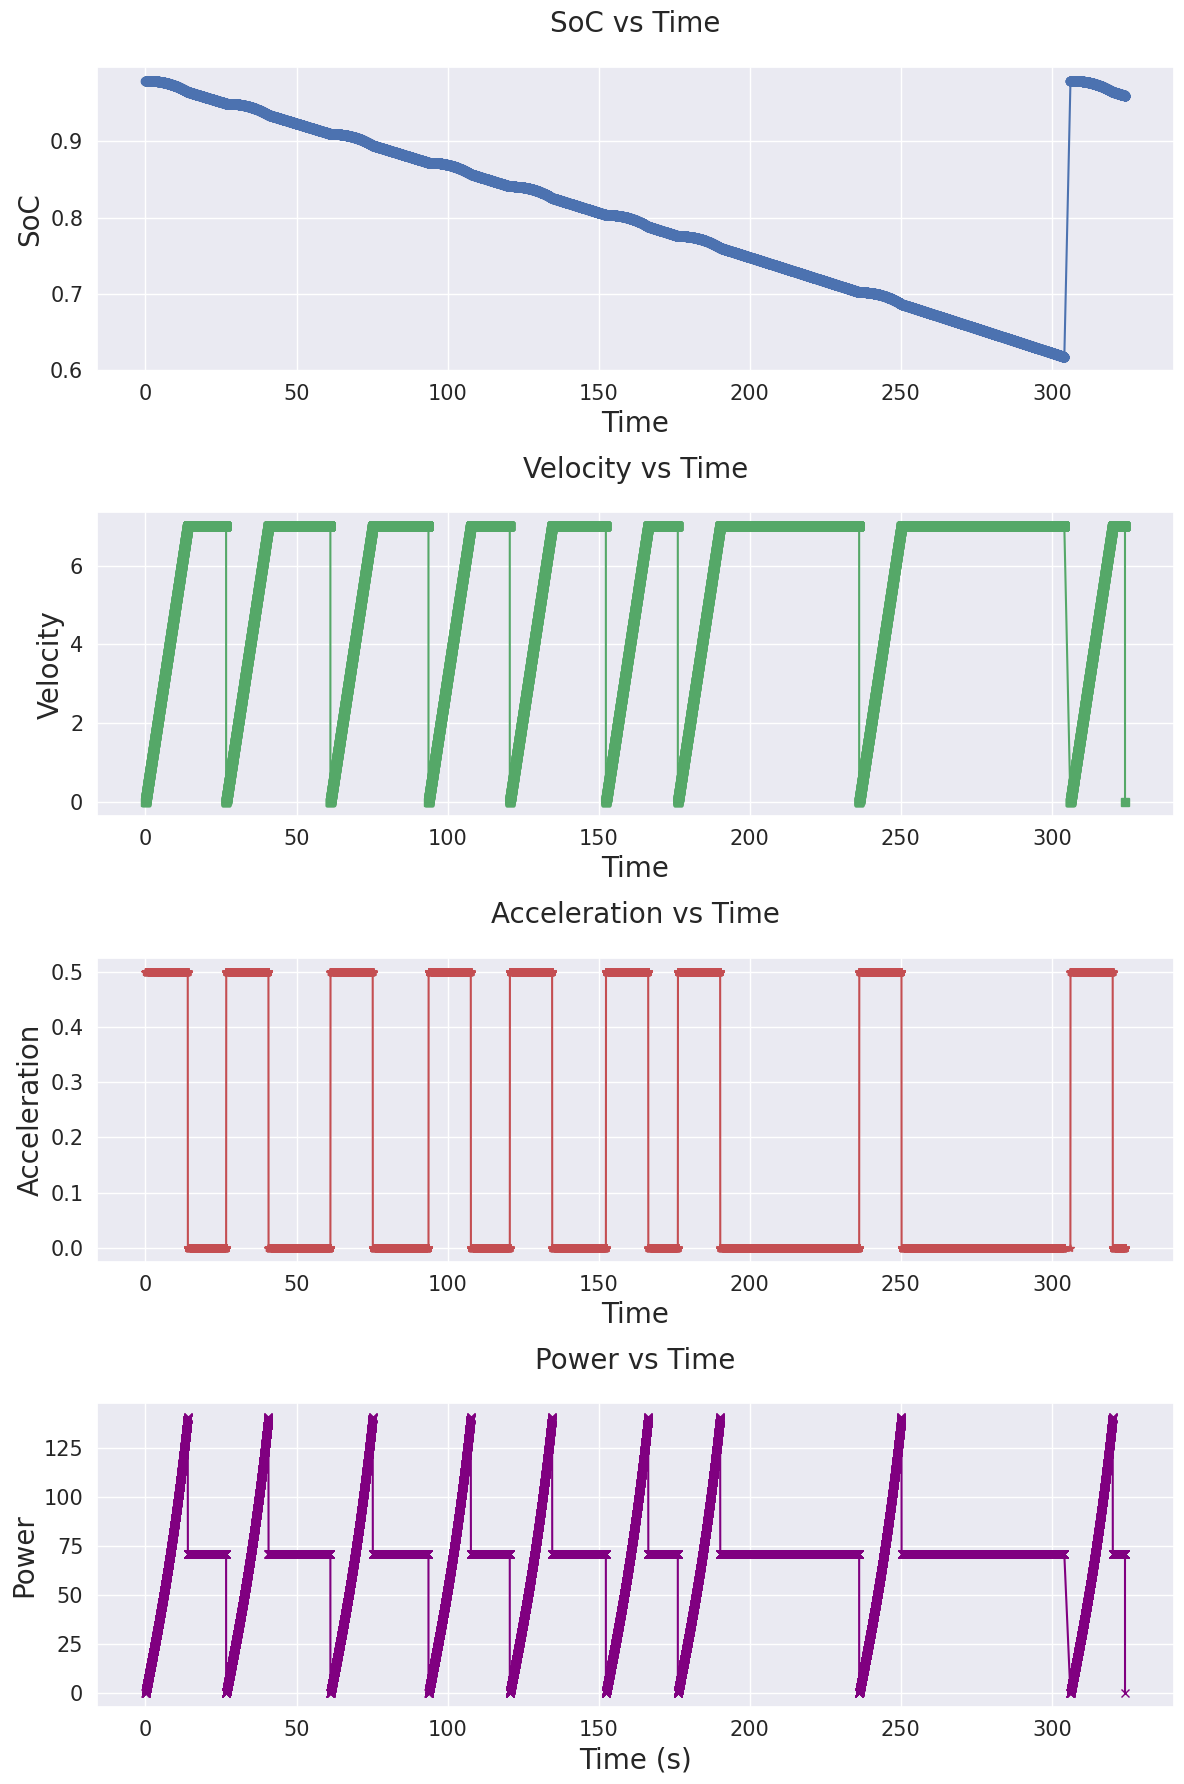

In [36]:
times = [entry['Time'] for entry in data[0]]
socs = [entry['soc'] for entry in data[0]]
velocities = [entry['velocity'] for entry in data[0]]
accelerations = [entry['acceleration'] for entry in data[0]]
powers = [entry['power'] for entry in data[0]]

# Create subplots for each parameter
plt.figure(figsize=(12, 18))

# Plot SoC
plt.subplot(411)
plt.plot(times, socs, marker='o', color='b')
plt.xlabel('Time')
plt.ylabel('SoC')
plt.title('SoC vs Time')

# Plot Velocity
plt.subplot(412)
plt.plot(times, velocities, marker='s', color='g')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity vs Time')

# Plot Acceleration
plt.subplot(413)
plt.plot(times, accelerations, marker='*', color='r')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Acceleration vs Time')

# Plot Power
plt.subplot(414)
plt.plot(times, powers, marker='x', color='purple')
plt.xlabel('Time (s)')
plt.ylabel('Power')
plt.title('Power vs Time')

plt.tight_layout()
plt.show()

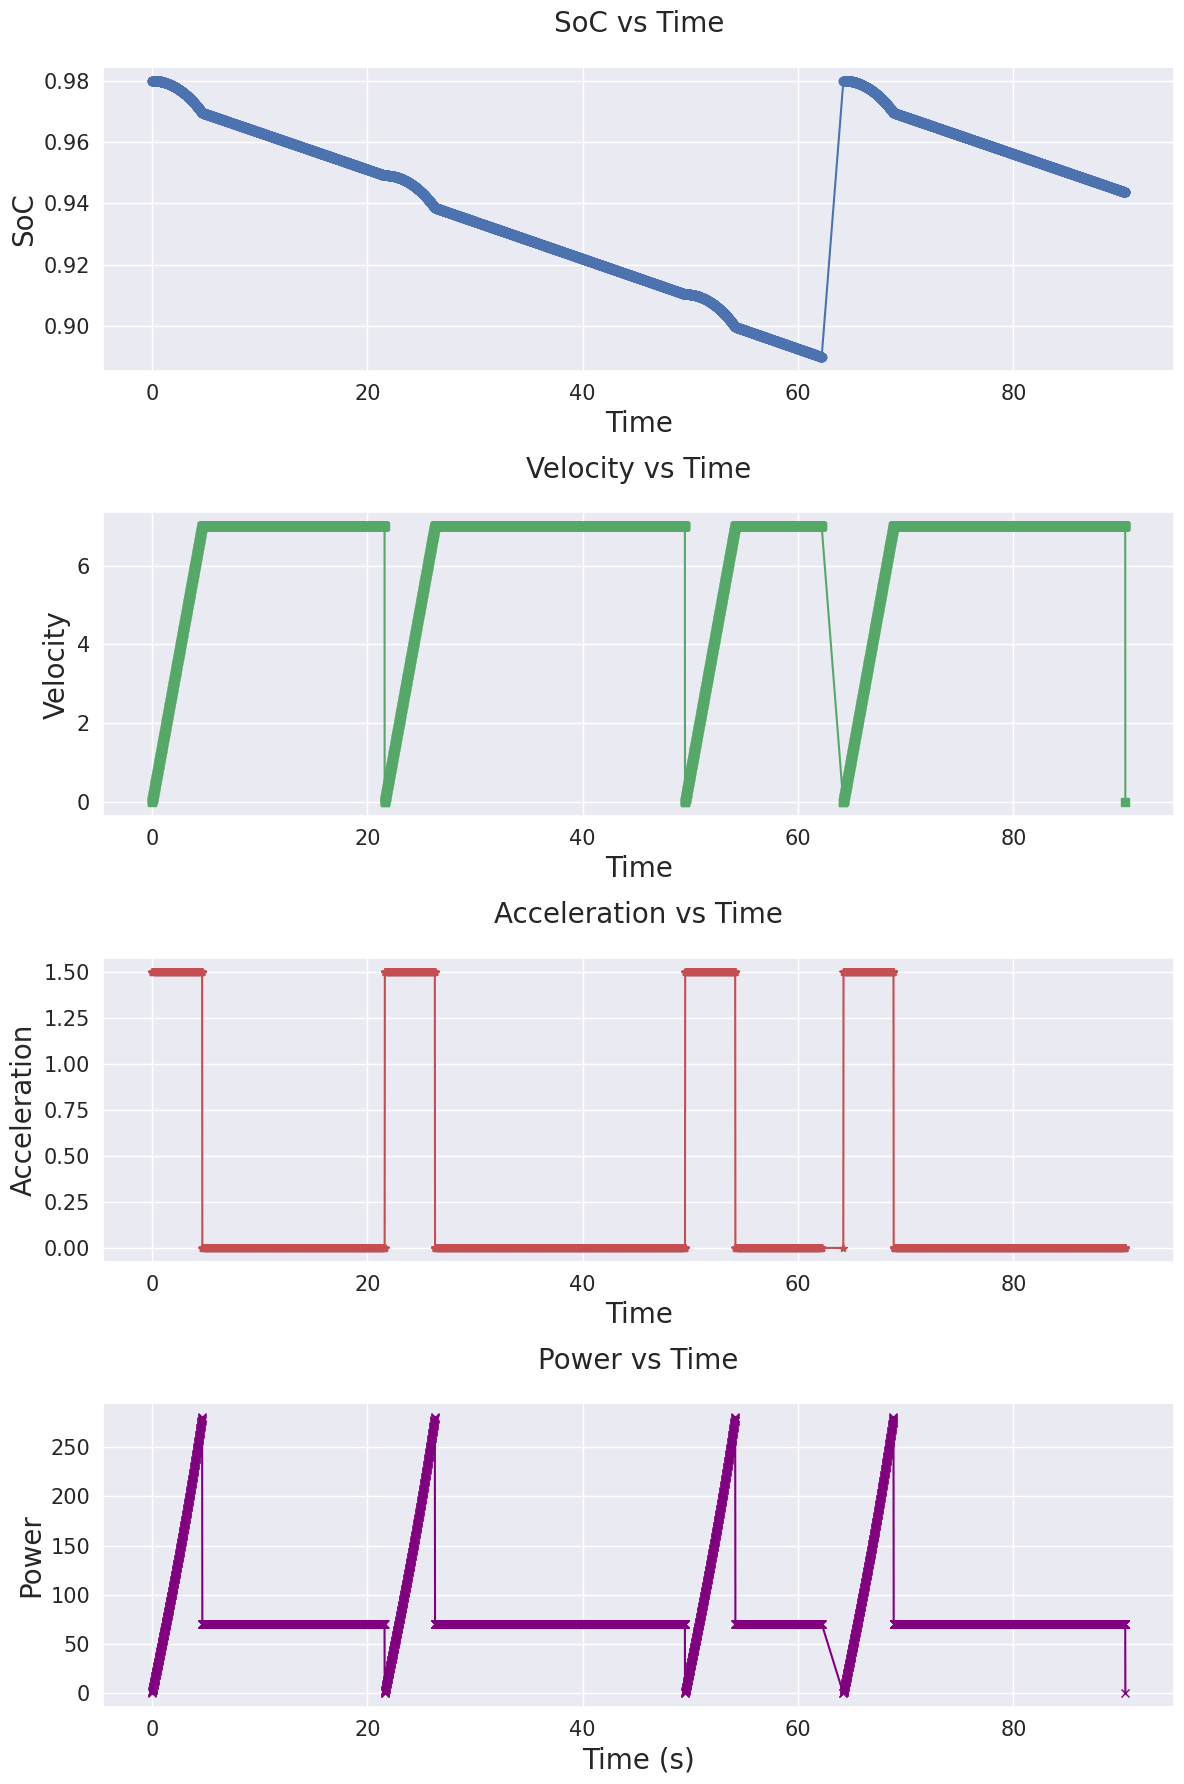

In [37]:
times = [entry['Time'] for entry in data[1]]
socs = [entry['soc'] for entry in data[1]]
velocities = [entry['velocity'] for entry in data[1]]
accelerations = [entry['acceleration'] for entry in data[1]]
powers = [entry['power'] for entry in data[1]]

# Create subplots for each parameter
plt.figure(figsize=(12, 18))

# Plot SoC
plt.subplot(411)
plt.plot(times, socs, marker='o', color='b')
plt.xlabel('Time')
plt.ylabel('SoC')
plt.title('SoC vs Time')

# Plot Velocity
plt.subplot(412)
plt.plot(times, velocities, marker='s', color='g')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity vs Time')

# Plot Acceleration
plt.subplot(413)
plt.plot(times, accelerations, marker='*', color='r')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Acceleration vs Time')

# Plot Power
plt.subplot(414)
plt.plot(times, powers, marker='x', color='purple')
plt.xlabel('Time (s)')
plt.ylabel('Power')
plt.title('Power vs Time')

plt.tight_layout()
plt.show()

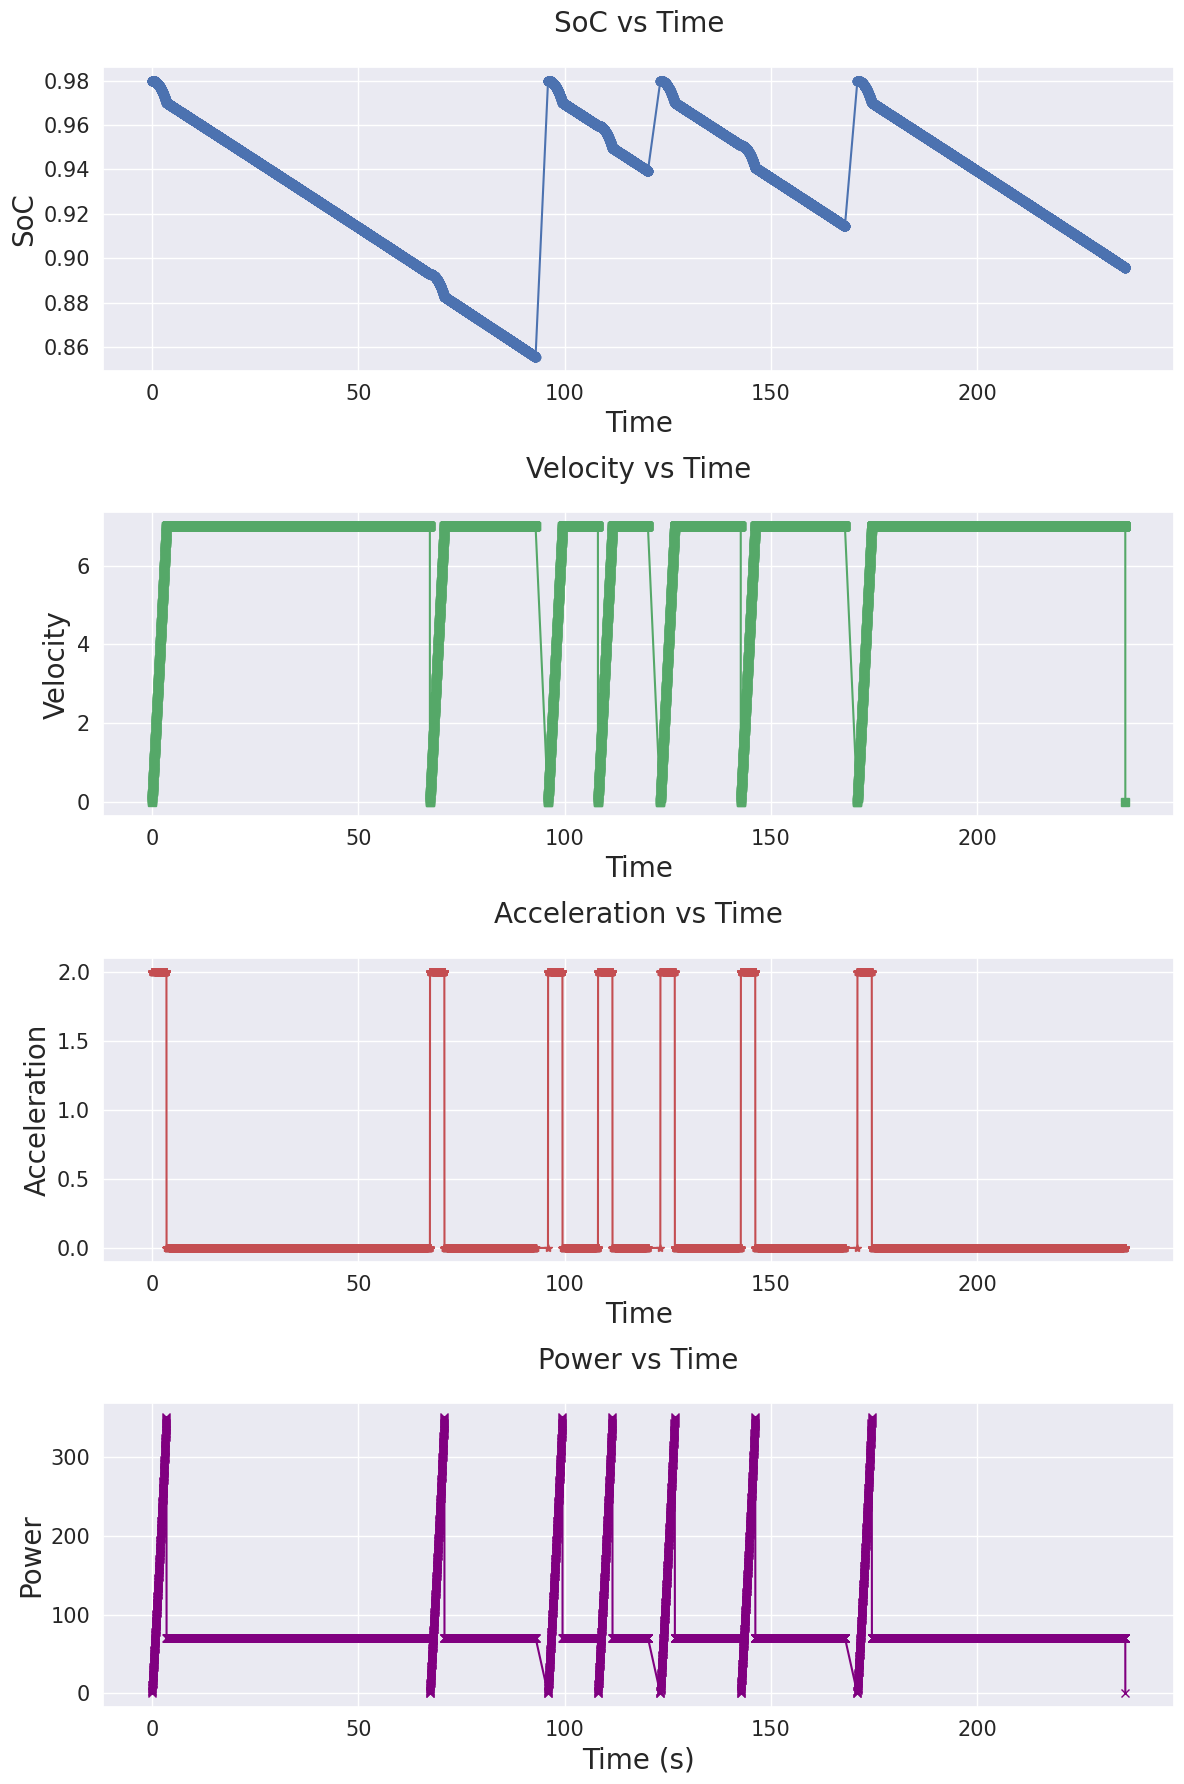

In [ ]:
times = [entry['Time'] for entry in data[2]]
socs = [entry['soc'] for entry in data[2]]
velocities = [entry['velocity'] for entry in data[2]]
accelerations = [entry['acceleration'] for entry in data[2]]
powers = [entry['power'] for entry in data[2]]

# Create subplots for each parameter
plt.figure(figsize=(12, 18))

# Plot SoC
plt.subplot(411)
plt.plot(times, socs, marker='o', color='b')
plt.xlabel('Time')
plt.ylabel('SoC')
plt.title('SoC vs Time')

# Plot Velocity
plt.subplot(412)
plt.plot(times, velocities, marker='s', color='g')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity vs Time')

# Plot Acceleration
plt.subplot(413)
plt.plot(times, accelerations, marker='*', color='r')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Acceleration vs Time')

# Plot Power
plt.subplot(414)
plt.plot(times, powers, marker='x', color='purple')
plt.xlabel('Time (s)')
plt.ylabel('Power')
plt.title('Power vs Time')

plt.tight_layout()
plt.show()

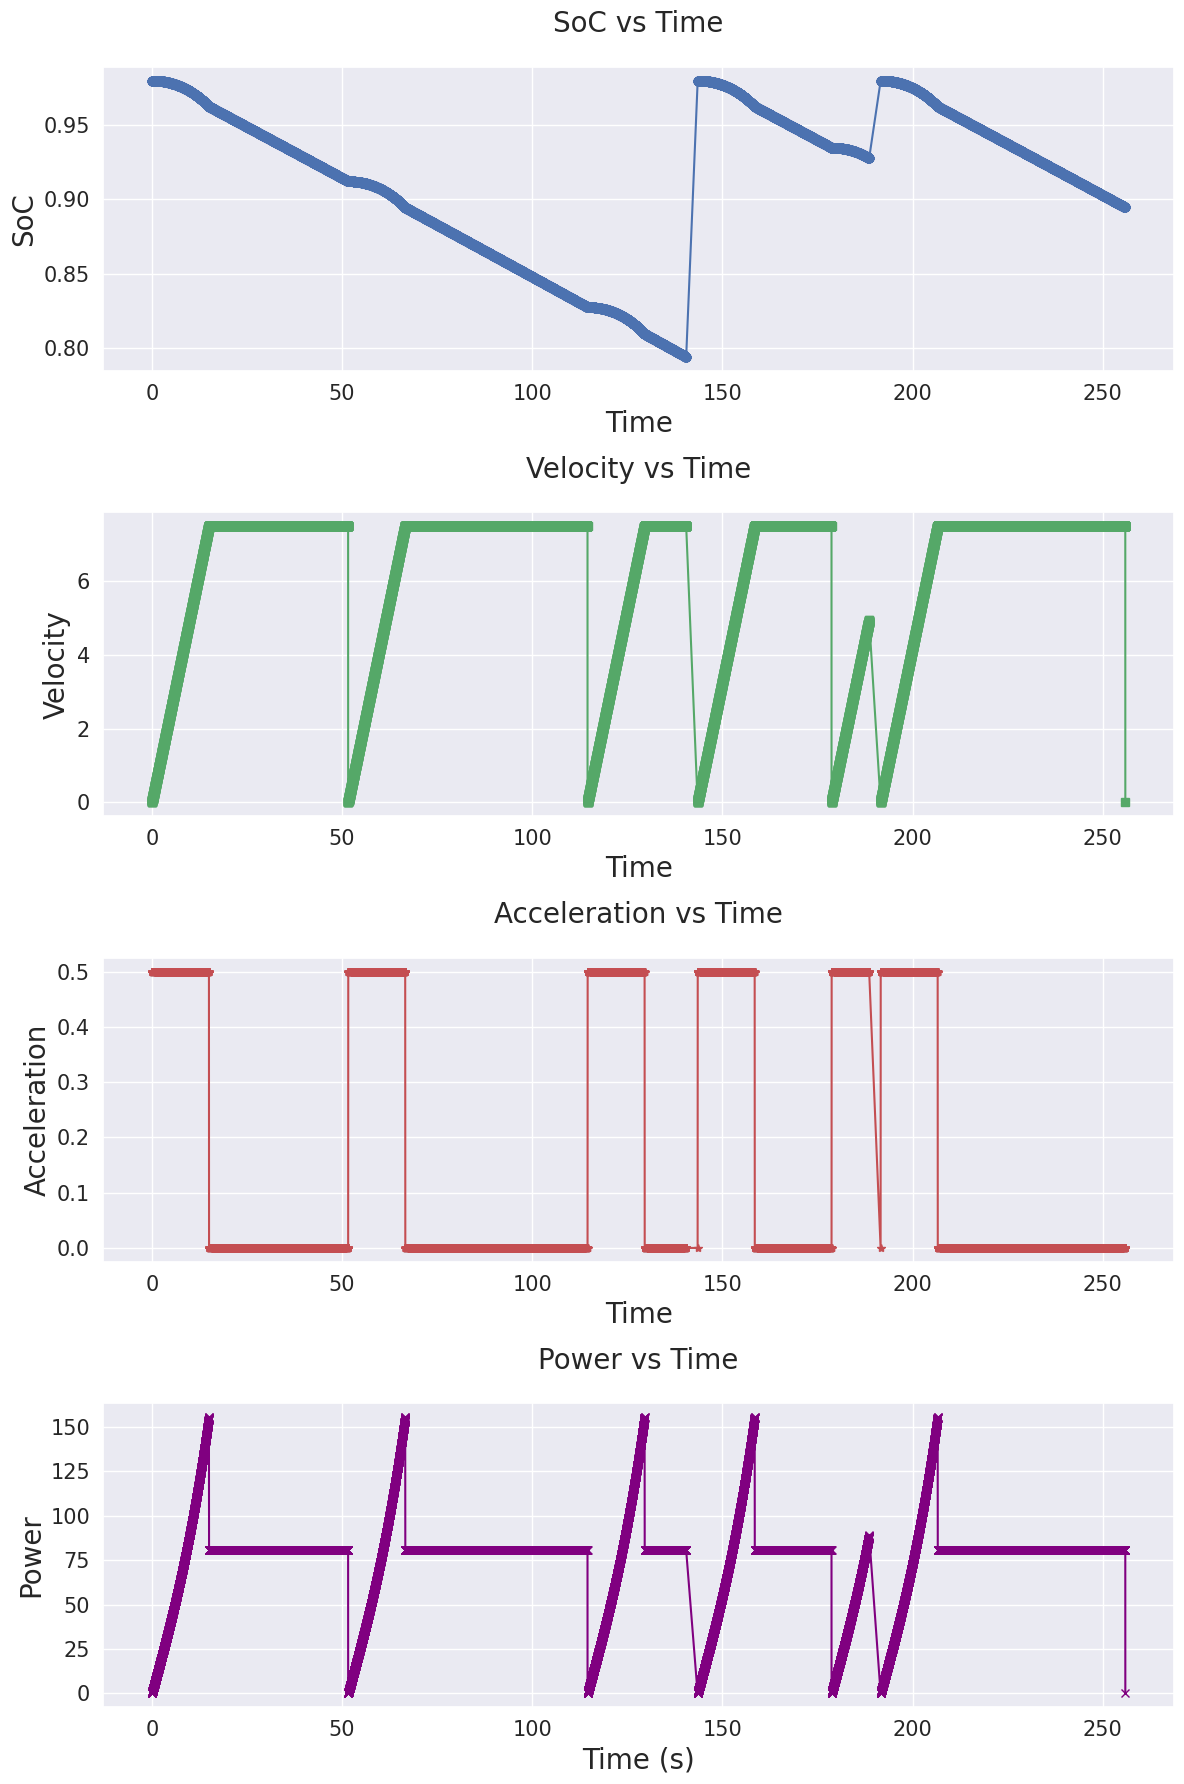

In [ ]:
times = [entry['Time'] for entry in data[3]]
socs = [entry['soc'] for entry in data[3]]
velocities = [entry['velocity'] for entry in data[3]]
accelerations = [entry['acceleration'] for entry in data[3]]
powers = [entry['power'] for entry in data[3]]

# Create subplots for each parameter
plt.figure(figsize=(12, 18))

# Plot SoC
plt.subplot(411)
plt.plot(times, socs, marker='o', color='b')
plt.xlabel('Time')
plt.ylabel('SoC')
plt.title('SoC vs Time')

# Plot Velocity
plt.subplot(412)
plt.plot(times, velocities, marker='s', color='g')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity vs Time')

# Plot Acceleration
plt.subplot(413)
plt.plot(times, accelerations, marker='*', color='r')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Acceleration vs Time')

# Plot Power
plt.subplot(414)
plt.plot(times, powers, marker='x', color='purple')
plt.xlabel('Time (s)')
plt.ylabel('Power')
plt.title('Power vs Time')

plt.tight_layout()
plt.show()

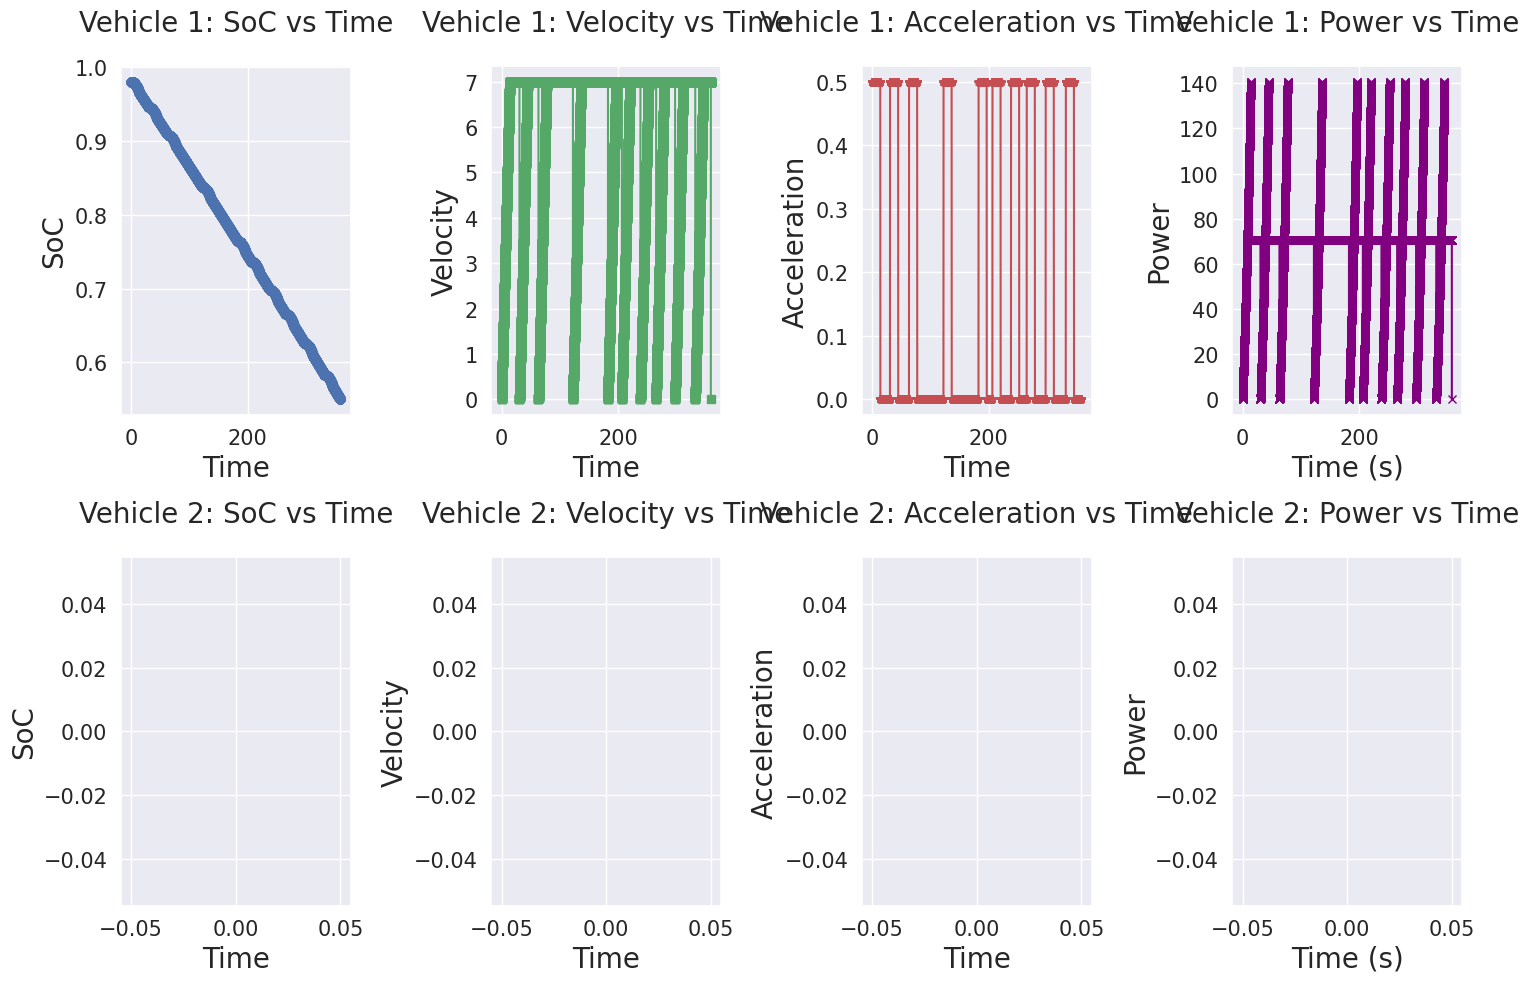

In [ ]:

fig, axs = plt.subplots(len(data), 4, figsize=(15, 5*len(data)))

for i, vehicle_data in enumerate(data):
    times = [entry['Time'] for entry in vehicle_data]
    socs = [entry['soc'] for entry in vehicle_data]
    velocities = [entry['velocity'] for entry in vehicle_data]
    accelerations = [entry['acceleration'] for entry in vehicle_data]
    powers = [entry['power'] for entry in vehicle_data]

    # Plot SoC
    axs[i, 0].plot(times, socs, marker='o', color='b')
    axs[i, 0].set_xlabel('Time')
    axs[i, 0].set_ylabel('SoC')
    axs[i, 0].set_title(f'Vehicle {i+1}: SoC vs Time')

    # Plot Velocity
    axs[i, 1].plot(times, velocities, marker='s', color='g')
    axs[i, 1].set_xlabel('Time')
    axs[i, 1].set_ylabel('Velocity')
    axs[i, 1].set_title(f'Vehicle {i+1}: Velocity vs Time')

    # Plot Acceleration
    axs[i, 2].plot(times, accelerations, marker='*', color='r')
    axs[i, 2].set_xlabel('Time')
    axs[i, 2].set_ylabel('Acceleration')
    axs[i, 2].set_title(f'Vehicle {i+1}: Acceleration vs Time')

    # Plot Power
    axs[i, 3].plot(times, powers, marker='x', color='purple')
    axs[i, 3].set_xlabel('Time (s)')
    axs[i, 3].set_ylabel('Power')
    axs[i, 3].set_title(f'Vehicle {i+1}: Power vs Time')

plt.tight_layout()
plt.show()

In [ ]:
time_values

[{},
 {5: 9.01,
  11: 9.739999999999997,
  7: 9.04,
  2: 9.069999999999999,
  4: 9.109999999999998,
  1: 9.169999999999998,
  9: 9.239999999999998,
  8: 9.319999999999999,
  6: 9.409999999999998,
  3: 9.509999999999998}]

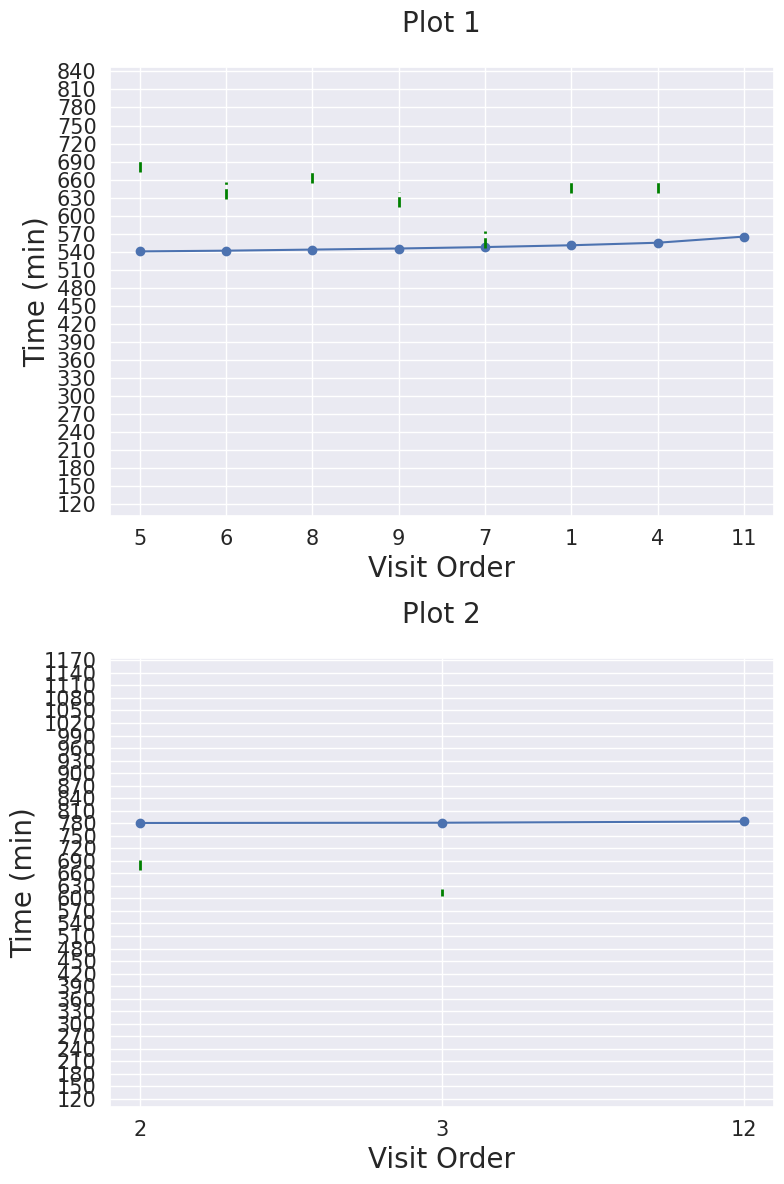

In [38]:
import matplotlib.pyplot as plt
# Convert hours to minutes for start_time and end_time in client_time_windows
client_time_windows_min = [(x[0] * 60, x[1] * 60) for x in client_time_windows]

fig, axs = plt.subplots(len(time_values), 1, figsize=(8, 6 * len(time_values)))

for idx, data in enumerate(time_values, start=1):
    if not data:  # Check if the data is empty
        continue
    keys = list(data.keys())

    # Convert hours to minutes for times in data
    times_min = [value * 60 for value in data.values()]

    order_of_visit = [key for key in keys]

    ax = axs[idx - 1]

    ax.plot(range(1, len(order_of_visit) + 1), times_min, marker='o', linestyle='-')

    for i, key in enumerate(order_of_visit):
        if key <= num_clients:
            start_time_min, end_time_min = client_time_windows_min[key]
            ax.vlines(x=i + 1, ymin=start_time_min, ymax=end_time_min, colors='green', linestyle='--',
                      linewidth=2, label=f'Customer {key} Time Window')

    ax.set_xlabel('Visit Order')
    ax.set_ylabel('Time (min)')
    ax.set_title(f'Plot {idx}')
    ax.set_xticks(range(1, len(order_of_visit) + 1))
    ax.set_xticklabels(order_of_visit)
    ax.grid(True)

    # Adjust y-axis limits for better visibility and add grid lines
    ax.set_ylim(100, max(times_min) * 1.5)  # Setting y-axis limits
    ax.yaxis.grid(True)  # Adding grid lines for y-axis
    ax.yaxis.set_major_locator(plt.MultipleLocator(30))  # Increase spacing between ticks on y-axis

plt.tight_layout()
plt.show()